# Libraries

In [1]:
import random

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Subset
from torch.optim import AdamW

from transformers.optimization import get_cosine_schedule_with_warmup
import torch_geometric as pyg
from torch_geometric.nn.pool import global_mean_pool
from torch_geometric.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

/home/leffff/PycharmProjects/misis-ai-course-final-project-2023/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        # torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
        


In [3]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class TrainingConfig:
    # Training
    batch_size = 2048
    epochs = 50
    learning_rate = 1e-2
    lr_warmup_steps = 500

    device = "cuda"
    random_state = 42


config = TrainingConfig()
seed_everything(config.random_state)

# Data

In [4]:
df = pd.read_excel("data/19_35000.xlsx", index_col=0).reset_index(drop=True)
df

,Title,IC50,SMILES
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...,...
36372,CHEMBL3699085,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...
36373,CHEMBL109004,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O
36374,CHEMBL2259758,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...
36375,CHEMBL109781,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O


## Clean

In [5]:
perc_99 = np.percentile(df["IC50"], 99)
df = df[df["IC50"] <= perc_99]

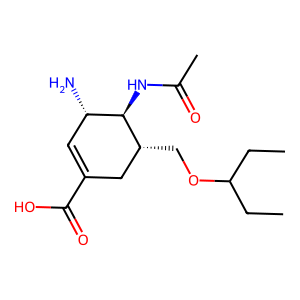

In [6]:
from rdkit import Chem
from rdkit.Chem import Draw

m = Chem.MolFromSmiles(df["SMILES"].tolist()[1])
img = Draw.MolToImage(m)
img

In [7]:
x = pyg.utils.smiles.from_smiles(df["SMILES"].tolist()[1])

In [8]:
class MolDataset(Dataset):
    def __init__(self, df):
        super(MolDataset, self).__init__()
        self.smiles = df["SMILES"].tolist()
        self.target = df["IC50"].tolist()
        
    def __len__(self):
        return len(self.smiles)
        
        
    def __getitem__(self, idx):
        x = pyg.utils.smiles.from_smiles(self.smiles[idx])
        return x, self.target[idx]

In [9]:
train_inds, test_inds = train_test_split(np.arange(df.shape[0]))
train_inds

array([14264, 22771, 18773, ..., 11284,   860, 15795])

In [10]:
dataset = MolDataset(df)

train_loader = DataLoader(
    Subset(dataset, train_inds),
    shuffle=True,
    batch_size=config.batch_size
)

eval_loader = DataLoader(
    Subset(dataset, test_inds),
    shuffle=True,
    batch_size=config.batch_size
)

/home/leffff/PycharmProjects/misis-ai-course-final-project-2023/.venv/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
all_node_features = []
all_edge_features = []

for i in tqdm(range(len(dataset))):
    all_node_features.append(dataset[i][0].x)
    all_edge_features.append(dataset[i][0].edge_attr)

all_node_features = torch.cat(all_node_features, dim=0)
all_edge_features = torch.cat(all_edge_features, dim=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36013/36013 [00:36<00:00, 985.86it/s]


In [12]:
all_node_features.shape

torch.Size([905938, 9])

In [13]:
node_vocab_sizes = []

for i in range(9):
    inds, counts = all_node_features[:, i].unique(return_counts=True)
    print(inds)
    node_vocab_sizes.append(inds.max().item() + 1)

node_vocab_sizes

tensor([ 1,  5,  6,  7,  8,  9, 11, 14, 15, 16, 17, 30, 34, 35, 53])
tensor([0, 1, 2])
tensor([0, 1, 2, 3, 4])
tensor([4, 5, 6, 7])
tensor([0, 1, 2, 3])
tensor([0])
tensor([1, 2, 3, 4])
tensor([0, 1])
tensor([0, 1])


[54, 3, 5, 8, 4, 1, 5, 2, 2]

In [14]:
edge_vocab_sizes = []

for i in range(3):
    inds, counts = all_edge_features[:, i].unique(return_counts=True)
    print(inds)
    edge_vocab_sizes.append(inds.max().item() + 1)

edge_vocab_sizes

tensor([ 1,  2,  3, 12])
tensor([0, 2, 3])
tensor([0, 1])


[13, 4, 2]

# Model

In [15]:
from torch import nn

class RegresisionGNN(torch.nn.Module):
    def __init__(self, node_vocab_sizes, edge_vocab_sizes, backbone, hidden_dim, backbone_dim, pooling_f=global_mean_pool):
        super(RegresisionGNN, self).__init__()
        self.node_vocab_sizes, self.edge_vocab_sizes = node_vocab_sizes, edge_vocab_sizes
        self.node_encoders = nn.ModuleList([nn.Embedding(size, hidden_dim) for size in node_vocab_sizes])
        self.edge_encoders = nn.ModuleList([nn.Embedding(size, hidden_dim) for size in edge_vocab_sizes])
        
        self.backbone = backbone
        self.pooling = pooling_f
        self.out = pyg.nn.Linear(backbone_dim, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = torch.cat([self.node_encoders[i](x[:, i]) for i in range(x.shape[1])], dim=1)
        edge_attr = torch.cat([self.edge_encoders[i](edge_attr[:, i]) for i in range(edge_attr.shape[1])], dim=1)
        
        node_features = self.backbone(
            x=x, 
            edge_index=edge_index, 
            edge_attr=edge_attr
        )

        batch_features = self.pooling(node_features, batch)
        
        return self.out(batch_features)

hidden_dim = 32
backbone = pyg.nn.models.GraphSAGE(in_channels=hidden_dim * 9, hidden_channels=hidden_dim * 2, num_layers=4, out_channels=hidden_dim)
model = RegresisionGNN(node_vocab_sizes, edge_vocab_sizes, backbone, hidden_dim=hidden_dim, backbone_dim=hidden_dim)
model

RegresisionGNN(
  (node_encoders): ModuleList(
    (0): Embedding(54, 32)
    (1): Embedding(3, 32)
    (2): Embedding(5, 32)
    (3): Embedding(8, 32)
    (4): Embedding(4, 32)
    (5): Embedding(1, 32)
    (6): Embedding(5, 32)
    (7-8): 2 x Embedding(2, 32)
  )
  (edge_encoders): ModuleList(
    (0): Embedding(13, 32)
    (1): Embedding(4, 32)
    (2): Embedding(2, 32)
  )
  (backbone): GraphSAGE(288, 32, num_layers=4)
  (out): Linear(32, 1, bias=True)
)

In [16]:
optimizer = AdamW(model.parameters(), lr=config.learning_rate)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_loader) * config.epochs),
)

loss_function = torch.nn.L1Loss()

# Let's Train

In [17]:
def train_epoch(model, loader, loss_function, optimizer, scheduler, device):
    model.train()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        data, y = batch
        data, y = data.to(device), y.to(device)
        output = model(data)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).sigmoid().detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"TRAIN Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy())}
        
        
def eval_epoch(model, loader, loss_function, device):
    model.eval()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        data, y = batch
        data, y = data.to(device), y.to(device)
        
        with torch.no_grad():
            output = model(data)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).sigmoid().detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"EVAL Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy())}

In [18]:
train_logs, eval_logs = [], []

for i in range(config.epochs):
    train_log = train_epoch(
        model=model, 
        loader=train_loader, 
        loss_function=loss_function, 
        optimizer=optimizer,
        scheduler=scheduler,
        device=config.device
    )
    
    eval_log = eval_epoch(
        model=model, 
        loader=eval_loader, 
        loss_function=loss_function, 
        device=config.device
    )

    print(train_log, eval_log)
    
    train_logs.append(train_log)
    eval_logs.append(eval_log)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


{'TRAIN Loss': {4.9811829158238}, 'MAE': {4.495075225830078}, 'R2': -0.35082873497786604} {'EVAL Loss': {4.596202945709228}, 'MAE': {4.391646862030029}, 'R2': -0.3540527368370012}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


{'TRAIN Loss': {3.8505178689956665}, 'MAE': {4.2664594650268555}, 'R2': -0.306120420531258} {'EVAL Loss': {3.5284852504730226}, 'MAE': {4.0899224281311035}, 'R2': -0.29032012982304645}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


{'TRAIN Loss': {3.3434616838182722}, 'MAE': {4.129385471343994}, 'R2': -0.27859980636331505} {'EVAL Loss': {3.195593500137329}, 'MAE': {4.1132893562316895}, 'R2': -0.2954277098064124}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


{'TRAIN Loss': {3.1841822181429182}, 'MAE': {4.131254196166992}, 'R2': -0.27895667793849777} {'EVAL Loss': {3.163180112838745}, 'MAE': {4.099649429321289}, 'R2': -0.2922937783505033}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


{'TRAIN Loss': {3.132325989859445}, 'MAE': {4.1318678855896}, 'R2': -0.2789347771402746} {'EVAL Loss': {3.122006893157959}, 'MAE': {4.102890968322754}, 'R2': -0.29288211511539086}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


{'TRAIN Loss': {3.1368819645472934}, 'MAE': {4.132115840911865}, 'R2': -0.27899535318296653} {'EVAL Loss': {3.130122423171997}, 'MAE': {4.103298664093018}, 'R2': -0.29303071174715867}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


{'TRAIN Loss': {3.165177192006792}, 'MAE': {4.13197660446167}, 'R2': -0.27902261221403224} {'EVAL Loss': {3.1302630424499513}, 'MAE': {4.103724002838135}, 'R2': -0.29311677629651545}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


{'TRAIN Loss': {3.145157183919634}, 'MAE': {4.131972312927246}, 'R2': -0.27903672498002896} {'EVAL Loss': {3.1070264339447022}, 'MAE': {4.105741024017334}, 'R2': -0.2934554141309502}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


{'TRAIN Loss': {3.1330881799970354}, 'MAE': {4.132678508758545}, 'R2': -0.27912932218331377} {'EVAL Loss': {3.1610116958618164}, 'MAE': {4.10987663269043}, 'R2': -0.29451580139297584}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


{'TRAIN Loss': {3.1141239745276317}, 'MAE': {4.1326680183410645}, 'R2': -0.27925762454851477} {'EVAL Loss': {3.108564519882202}, 'MAE': {4.101319313049316}, 'R2': -0.29266653816500887}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


{'TRAIN Loss': {3.1180669920785085}, 'MAE': {4.1323394775390625}, 'R2': -0.27922985178489634} {'EVAL Loss': {3.165471839904785}, 'MAE': {4.113894462585449}, 'R2': -0.29532825724441514}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


{'TRAIN Loss': {3.1622590848377774}, 'MAE': {4.13387393951416}, 'R2': -0.27948538132149414} {'EVAL Loss': {3.0788368225097655}, 'MAE': {4.103499412536621}, 'R2': -0.293099310628149}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


{'TRAIN Loss': {3.1207240649632046}, 'MAE': {4.1326141357421875}, 'R2': -0.2792807970830251} {'EVAL Loss': {3.1275973320007324}, 'MAE': {4.100174427032471}, 'R2': -0.29243995856112015}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


{'TRAIN Loss': {3.175481012889317}, 'MAE': {4.135594367980957}, 'R2': -0.28003398509723243} {'EVAL Loss': {3.1685952663421633}, 'MAE': {4.124212741851807}, 'R2': -0.29754417794348176}


 21%|███████████████████████████                                                                                                   | 3/14 [00:04<00:16,  1.49s/it]


KeyboardInterrupt: 